In [ ]:
import matplotlib.pyplot as plt
from visualizer import print_result, display_stocks_graph
import pandas as pd
import yfinance as yf
import time
import numpy as np

#### Get Yahoo Finance Data

In [ ]:
import os
from import_stocks import read_stock_symbols
from yahoo_data_provider import get_yahoo_data

# Define the base path relative to the current working directory
base_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'assets'))
stocks_symbol_list_path = os.path.join(base_path, 'nasdaq_100_stocks.csv')


######### Define no of stocks ###############3
no_of_stocks = 6


stocks = read_stock_symbols(stocks_symbol_list_path, num_symbols=no_of_stocks)
start_date=(2018, 1, 1)
end_date=(2020, 1, 1)

data, tickers, mu, sigma = get_yahoo_data(stocks, start_date, end_date)

print("Stocks: ", stocks)
print("Mean return: ", mu)
print("Covariance: ", sigma)

In [ ]:
# plot sigma
plt.imshow(sigma, interpolation="nearest")
plt.show()

In [ ]:
display_stocks_graph(data)

### Define Portfolio Optimization Problem

In [ ]:
from portfolio import define_portfolio_optimization_problem

q = 0.5  # set risk factor
budget = 3  # set budget

portfolio, portfolio_quadratic_program = define_portfolio_optimization_problem(expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget)
print("Portfolio Quadratic Program: ", portfolio_quadratic_program)

### Solve the portfolio optimization problem

#### Solve using NumPyMinimumEigensolver (as a classical reference)

In [ ]:
from solver import solve_using_numpy_minimum_eigensolver

result = solve_using_numpy_minimum_eigensolver(portfolio_quadratic_program)

print_result(stocks, portfolio, result)

#### Solve using Solution using `SamplingVQE`

In [ ]:
from solver import solve_using_sampling_vqe

num_stocks = len(stocks)
result = solve_using_sampling_vqe(portfolio_quadratic_program, num_stocks)

print_result(stocks, portfolio, result)

#### Solve using Solution using `QAOA`

In [ ]:
from solver import solve_using_qaoa

num_stocks = len(stocks)
result = solve_using_qaoa(portfolio_quadratic_program)

print_result(stocks, portfolio, result)

In [ ]:
import matplotlib.pyplot as plt
from visualizer import print_result, display_stocks_graph
import pandas as pd
import yfinance as yf
import time
import numpy as np
from get_optimal_stocks import *
from datetime import datetime

# Define start and end dates
start = datetime(*start_date)
end = datetime(*end_date)

Portfolio_total_value = 1000000 # This is in dollar

# Create an empty dictionary to store dataframes
stock_data = {}

# Define the stock symbols (Yahoo Finance uses different symbols compared to Quandl)
stock_symbols = get_optimal_stocks(tickers, result) # Default :['JPM', 'C', 'BAC', 'WFC']

# Fetch data from Yahoo Finance
for stock_symbol in stock_symbols:
    try:
        stock_df = yf.download(stock_symbol, start=start, end=end)

        # Process the stock data
        stock_df['Normed Return'] = stock_df['Adj Close'] / stock_df.iloc[0]['Adj Close']

        # Store the dataframe in the dictionary
        stock_data[stock_symbol] = stock_df

    except Exception as e:
        print(f"Error retrieving data for symbol: {stock_symbol}. Error message: {e}")

# Access and display dataframes (similar to the original loop)
for stock_name, stock_df in stock_data.items():
    print(f"\n{stock_name} DataFrame Head:")
    print(stock_df.head())


import numpy as np

# Generate random allocations
allocations = np.random.rand(len(stock_symbols))
# Normalize allocations so they add up to 1
allocations /= allocations.sum()
print(allocations)

# Calculate and add position values to each dataframe
for stock_symbol, allocation in zip(stock_symbols, allocations):
    stock_df = stock_data[stock_symbol]
    stock_df['Allocation'] = stock_df['Normed Return'] * allocation
    stock_df['Position Values'] = stock_df['Allocation'] * Portfolio_total_value

# Display the head of the JPM dataframe with allocation and position values
print("\nJPM DataFrame with Allocation and Position Values Head:")
print(stock_data[stock_symbols[0]].head())

# Combine the position values into a single DataFrame and calculate the total position
portfolio_val = pd.concat([stock_data[symbol]['Position Values'] for symbol in stock_symbols], axis=1)
portfolio_val.columns = [f"{symbol} Pos" for symbol in stock_symbols]
portfolio_val['Total Pos'] = portfolio_val.sum(axis=1)

# Display the head of the portfolio valuation DataFrame
print("\nPortfolio Valuation DataFrame Head:")
print(portfolio_val.head())


In [ ]:
# Plot the total portfolio value
portfolio_val['Total Pos'].plot(figsize=(10, 8))
plt.title('Total Portfolio Value')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.show()

# Plot the individual stock position values
portfolio_val.drop('Total Pos', axis=1).plot(kind='line', figsize=(10, 8))
plt.title('Individual Stock Position Values')
plt.xlabel('Date')
plt.ylabel('Position Value')
plt.show()


portfolio_val['Daily Return'] = portfolio_val['Total Pos'].pct_change(1)
portfolio_val

In [ ]:
# Calculate the cumulative return
cum_ret = 100 * (portfolio_val['Total Pos'][-1] / portfolio_val['Total Pos'][0] - 1)
print('Our cumulative return is {} percent!'.format(cum_ret))

In [ ]:
portfolio_val['Daily Return'].mean()

In [ ]:
portfolio_val['Daily Return'].std()

In [ ]:
SR = portfolio_val['Daily Return'].mean()/portfolio_val['Daily Return'].std()
SR

In [ ]:
ASR = (252**0.5)*SR
ASR

In [ ]:
# Extract and combine the adjusted close prices into a single DataFrame for daily returns
close_data = {symbol: stock_data[symbol]['Adj Close'] for symbol in stock_symbols}

# Combine daily close prices into a single DataFrame
stocks = pd.DataFrame(close_data)

# Display the head of the daily returns DataFrame
print("\nDaily Returns DataFrame Head:")
print(stocks.head())

# Calculate logarithmic returns
log_ret = np.log(stocks / stocks.shift(1))

# Display the head of the logarithmic returns DataFrame
print("\nLogarithmic Returns DataFrame Head:")
print(log_ret.head())

In [ ]:
#calculate the log return mean of each stock
log_ret.mean() * 252

In [ ]:
# Compute pairwise covariance of columns
log_ret.cov()*252

In [ ]:
######## Trying one iteration ################

np.random.seed(101)

# Stock Columns
print('Stocks')
print(stocks.columns)
print('\n')

# Create Random Weights
print('Creating Random Weights')
weights = np.array(np.random.random(len(stock_symbols))) # changes to be done here 
print(weights)
print('\n')

# Rebalance Weights
print('Rebalance to sum to 1.0')
weights = weights / np.sum(weights)
print(weights)
print('\n')

# Expected Return
print('Expected Portfolio Return')
exp_ret = np.sum(log_ret.mean() * weights) *252
print(exp_ret)
print('\n')

# Expected Variance
print('Expected Volatility')
exp_vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))
print(exp_vol)
print('\n')

# Sharpe Ratio
SR = exp_ret/exp_vol
print('Sharpe Ratio')
print(SR)

In [ ]:
################## For multiple iteration : Monte Carlo ##########################3
num_ports = 50000

all_weights = np.zeros((num_ports,len(stocks.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for ind in range(num_ports):

    # Create Random Weights
    weights = np.array(np.random.random(len(stock_symbols))) # Change to be made here 

    # Rebalance Weights
    weights = weights / np.sum(weights)
    
    # Save Weights
    all_weights[ind,:] = weights

    # Expected Return
    ret_arr[ind] = np.sum((log_ret.mean() * weights) *252)

    # Expected Variance
    vol_arr[ind] = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))

    # Sharpe Ratio
    sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]

In [ ]:
sharpe_arr.max()

In [ ]:
sharpe_arr.argmax()

In [44]:
all_weights[1248,:]

weight_list = all_weights
print(weight_list[0])

# 
print(f'Values to be invested in each stock for portfolio of value {Portfolio_total_value} $')
for i in range(len(stock_symbols)):
    print(f'{stock_symbols[i]} : ${weight_list[0][i]* Portfolio_total_value} ')



[0.10145035 0.40532253 0.49322711]
Values to be invested in each stock for portfolio of value 1000000 $
AAPL : $101450.35351927289 
MSFT : $405322.53233710217 
AMZN : $493227.1141436249 


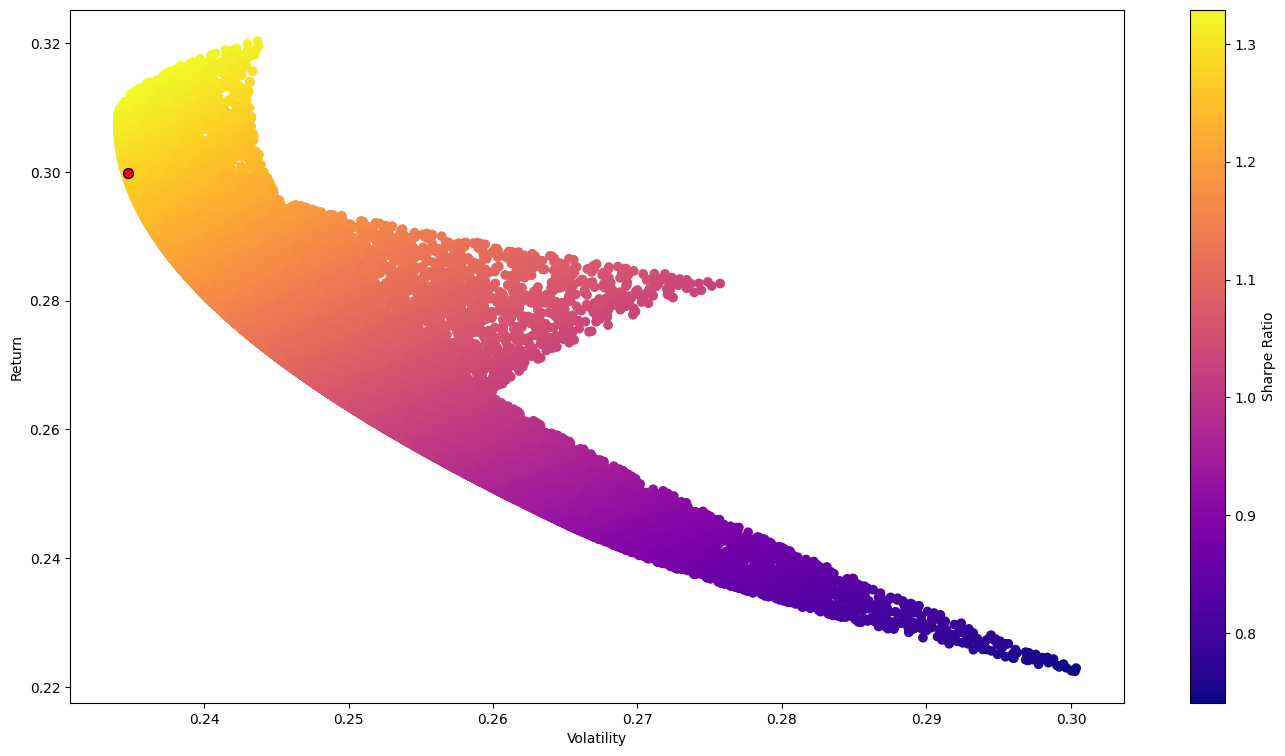

In [45]:
max_sr_ret = ret_arr[1248]
max_sr_vol = vol_arr[1248]
plt.figure(figsize=(17,9))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
# Add red dot for max SR
plt.scatter(max_sr_vol,max_sr_ret,c='red',s=50,edgecolors='black')

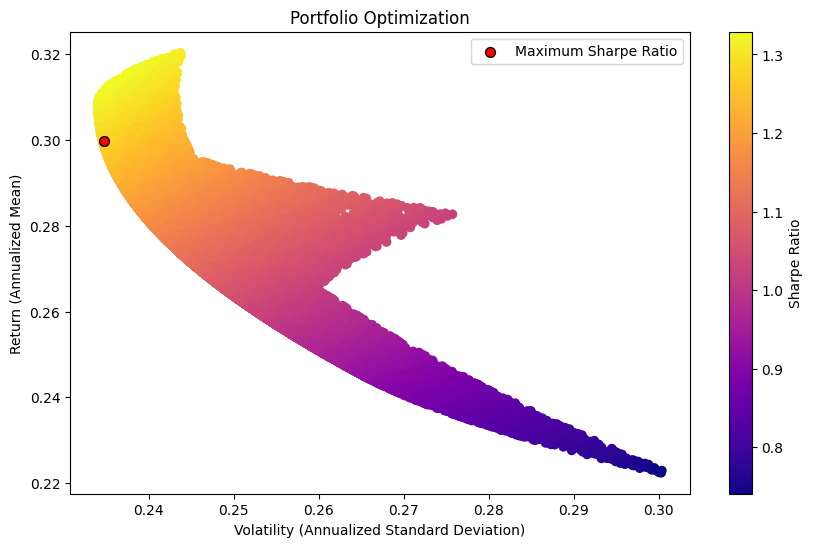

In [46]:
plt.figure(figsize=(10, 6))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(max_sr_vol, max_sr_ret, c='red', s=50, edgecolors='black', label='Maximum Sharpe Ratio')
plt.xlabel('Volatility (Annualized Standard Deviation)')
plt.ylabel('Return (Annualized Mean)')
plt.title('Portfolio Optimization')
plt.legend()
plt.show()


In [48]:
from scipy.optimize import minimize

def calc_portfolio_volatility(weights, log_returns):
    """
    Calculate the volatility of the portfolio given the weights
    """
    return np.sqrt(np.dot(weights.T, np.dot(log_returns.cov() * 252, weights)))

# Now you can use this function in your optimization process


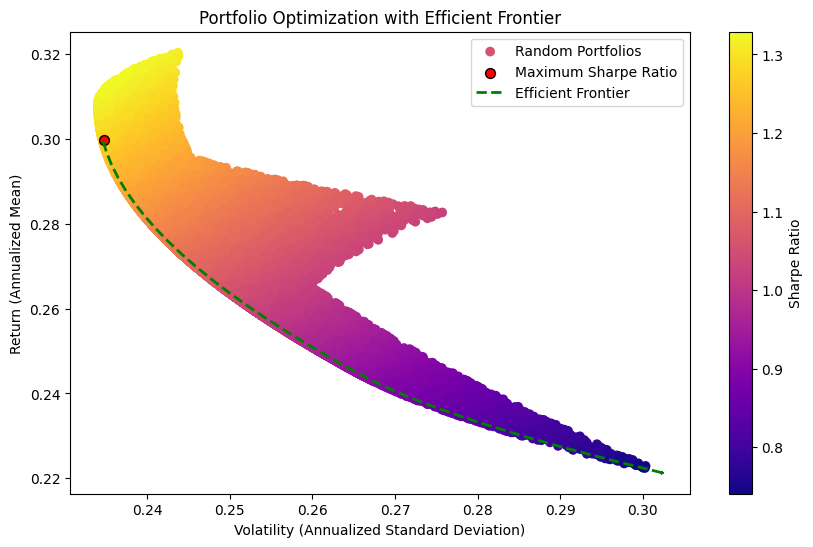

In [49]:
# Generate portfolios along the efficient frontier
target_returns = np.linspace(0.0, 0.3, 100)  # Adjust the range of target returns as needed
port_returns = []
port_volatility = []
port_sharpe_ratio = []

for target_return in target_returns:
    # Set up optimization constraints
    cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
            {'type': 'eq', 'fun': lambda x: np.sum((log_ret.mean() * 252) * x) - target_return})

    # Set up bounds for individual weights
    bounds = tuple((0, 1) for asset in range(len(stock_symbols)))

    # Initial guess (equal distribution)
    initial_guess = np.ones(len(stock_symbols)) / len(stock_symbols)

    # Perform optimization to minimize volatility
    optimized_result = minimize(calc_portfolio_volatility, initial_guess, args=(log_ret,), method='SLSQP',
                                bounds=bounds, constraints=cons)

    # Extract optimal weights
    optimized_weights = optimized_result.x

    # Calculate portfolio return, volatility, and Sharpe ratio
    port_return = np.sum((log_ret.mean() * 252) * optimized_weights)
    port_returns.append(port_return)
    port_volatility.append(np.sqrt(np.dot(optimized_weights.T, np.dot(log_ret.cov() * 252, optimized_weights))))
    port_sharpe_ratio.append(port_return / port_volatility[-1])

# Plot the Efficient Frontier
plt.figure(figsize=(10, 6))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='plasma', label='Random Portfolios')
plt.colorbar(label='Sharpe Ratio')
plt.scatter(max_sr_vol, max_sr_ret, c='red', s=50, edgecolors='black', label='Maximum Sharpe Ratio')
plt.plot(port_volatility, port_returns, 'g--', linewidth=2, label='Efficient Frontier')
plt.xlabel('Volatility (Annualized Standard Deviation)')
plt.ylabel('Return (Annualized Mean)')
plt.title('Portfolio Optimization with Efficient Frontier')
plt.legend()
plt.show()


In [ ]:
'''def get_ret_vol_sr(weights):
    """
    Takes in weights and returns back an array of mean return, mean volatility and sharpe ratio
    """
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))
    sr = ret/vol
    return np.array([ret,vol,sr])'''

In [ ]:
def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))
    sr = ret/vol
    return np.array([ret,vol,sr])


In [ ]:
from scipy.optimize import minimize

In [ ]:
def neg_sharpe(weights):
    return  get_ret_vol_sr(weights)[2] * -1

In [ ]:
# Constraints
def check_sum(weights):
    '''
    Returns 0 if sum of weights is 1.0
    '''
    return np.sum(weights) - 1
# By convention of minimize function it should be a function that returns zero for conditions
cons = ({'type':'eq','fun': check_sum})

In [ ]:
# 0-1 bounds for each weight
bounds = ((0, 1), (0, 1), (0, 1))

In [ ]:
# Initial Guess (equal distribution)
init_guess = [0.25,0.25,0.50]
# Sequential Least Squares Programming (SLSQP).
opt_results = minimize(neg_sharpe,init_guess,method='SLSQP',bounds=bounds,constraints=cons)
opt_results

In [ ]:
opt_results.x

In [ ]:
get_ret_vol_sr(opt_results.x)

In [ ]:
# Our returns go from 0 to somewhere along 0.2
# Create a linspace number of points to calculate x on
frontier_y = np.linspace(0,0.2,100) 
def minimize_volatility(weights):
    return  get_ret_vol_sr(weights)[1]
frontier_volatility = []
for possible_return in frontier_y:
    # function for return
    cons = ({'type':'eq','fun': check_sum},
            {'type':'eq','fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    
    result = minimize(minimize_volatility,init_guess,method='SLSQP',bounds=bounds,constraints=cons)
    
    frontier_volatility.append(result['fun'])
plt.figure(figsize=(17,9))
plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
# Add frontier line
plt.plot(frontier_volatility,frontier_y,'g--',linewidth=3)

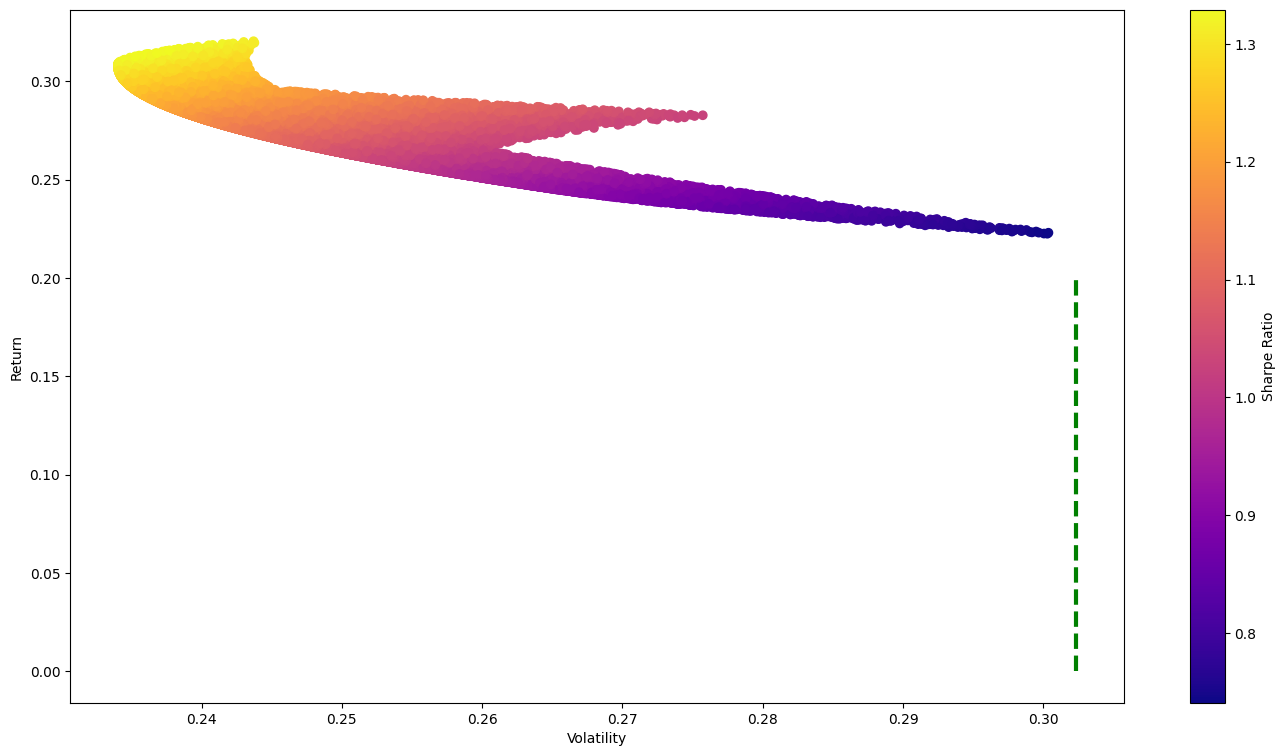

In [42]:
frontier_y = np.linspace(0,0.2,100) 
def minimize_volatility(weights):
    return  get_ret_vol_sr(weights)[1]
frontier_volatility = []
for possible_return in frontier_y:
    # function for return
    cons = ({'type':'eq','fun': check_sum},
            {'type':'eq','fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    
    result = minimize(minimize_volatility,init_guess,method='SLSQP',bounds=bounds,constraints=cons)
    

